In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle, random, choice, randint

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn.grn5 import GRNMain5 as GRNMain
from lib.sde.gene.gene5 import ParamGene5 as ParamGene, GeneMain5 as GeneMain
from lib.sde.mutate import SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from jf.utils.helper import provide_id

from lib.bank.generators import Solution, set_mutate_func
from lib.bank.scores import get_bb, fitness_multistep, ObjectiveStep
from lib.bank.params import BaseParam, callback_init
from lib.action import Action
from submodels.grn_auto_v1 import GRNCell

In [3]:
def hook_mutation(grn):
    # scratch and kill
    # kill
    if random() < 0.02:
        grn._params[:, randint(0, grn.nb_genes - 1)] = 0
        
    # scratch
    if random() < 0.1:
        possible_genes = np.where(grn._params.sum(axis=0) == 0)[0]
        if len(possible_genes):
            gene = choice(possible_genes)
            grn.genes[gene] = GeneMain(idx=gene, nb_genes=grn.nb_genes,
                                nb_membrane_gene=grn.nb_membrane_gene, params=grn._params,
                                generate_funcs=callback_init)
    
    # constraints
    grn._params[ParamGene.expr, 0] = 1

def hook_event_handler(cell_program):
    # prob **2 and **4
    q = np.array(cell_program.quantities)
    if random() > 1 - (q[0] / 2)**4:  # missing a reset
        return Action.Divide, GRNCell.Progenitor
    
    if random() > 1 - (q[1] / 2)**2:
        return Action.DiffNeuron, GRNCell.PostMitoticInfra
    
    return Action.NoOp, None

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
set_mutate_func(SparseMutator(hook=hook_mutation))

In [5]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [6]:
def individual_generator(id_=-1, cb_init=None):
    return Solution(GRNMain(7, 0, 1, generate_funcs=cb_init), id_=id_)

In [7]:
def score_grn(grn):
    params = np.array(grn._params)
    possible_genes = np.where(params.sum(axis=0) == 0)[0]
    return len(possible_genes) * 10.1234567

In [8]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    last_time = max(stats.time)
    stats = stats.set_index("time")
    prog = stats.loc[last_time]["progenitor_pop_size"]
    neuron = stats.loc[last_time]["neuron_pop_size"]
    
    # Score the deleted genes
    score_before = np.floor(max(1, 1000 + (neuron - prog**1.8)))

    return 1 / score_before

In [9]:
def get_bb(prun, grn):
    ccls = factories[prun.model](grn=grn, hooks=dict(event_handler=hook_event_handler))
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=prun.ts, verbose=False, start_population=prun.size,
                    max_pop_size=prun.max_cell_pop_size, cell_cls=ccls,
                    end_time=prun.end_time, start_time=prun.start_time, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [10]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    total_fitness = np.floor(total_fitness) + score_grn(grn)
    return total_fitness, bb.stats

In [11]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=0.05, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [12]:
example_steps = [
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

In [13]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [14]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [15]:
prun = BaseParam(
    start_time=56,
    name="check_simple_obj_r35",
    model="grn_auto1",
    n_genes=7,
    steps=example_steps,
)

res = main(prun)

Exporting at output/check_simple_obj_r35
[definition] 
    
    
[reload] Found generation 6
Step 3 passed !
[out] ++ Best 1790.1234567 for generation 350
[out] ++ Best 1877.0 for generation 357
[out] ++ Best 1897.0 for generation 360
[out] ++ Best 1927.0 for generation 363
Saving ...
[out] Step 400
[out] ++ Best 1982.0 for generation 413
Saving ...
[out] ++ Best 2019.0 for generation 452
Saving ...
[out] Step 500
Saving ...
Saving ...
[out] Step 600
Saving ...
[out] ++ Best 2035.0 for generation 677
Saving ...
[out] Step 700
Saving ...
[out] ++ Best 2044.0 for generation 752
Saving ...
[out] Step 800
Saving ...
[out] ++ Best 2076.0 for generation 874
Saving ...
[out] Step 900
[out] ++ Best 2114.0 for generation 903
[out] ++ Best 2220.0 for generation 910
Saving ...
Saving ...
[out] Step 1000
Saving ...
Saving ...
[out] Step 1100
Saving ...
Saving ...
[out] Step 1200
Saving ...
[out] ++ Best 2274.0 for generation 1269
Saving ...
[out] Step 1300
Saving ...
Saving ...
[out] Step 1400
Sav

In [16]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r35


In [17]:
sm = read_model("generation")

In [18]:
res = pick_best(exp.load(pick_last(exp)))

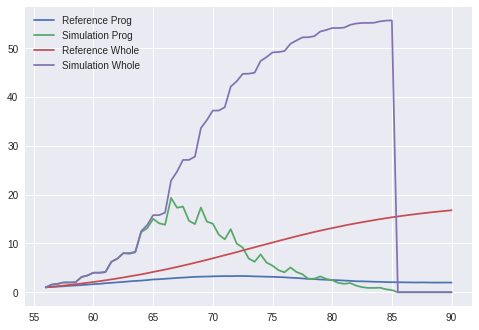

In [19]:
show_curve(res.stats, REF.stats)

In [21]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 1393.0 =======
>> G_0: init: 2.18; noise: 0.40; b: 2.10; m: 5.37; expr: 1.00; deg: 0.09; theta: 8.53; asym: 5.00; tree : 1
>> G_1: init: 0.35; noise: 0.60; b: 1.10; m: 6.83; expr: 1.06; deg: 0.10; theta: 6.82; asym: 5.00; tree : (-5 AND 2)
>> G_2: init: 0.96; noise: 0.65; b: 1.94; m: 6.86; expr: 0.88; deg: 0.10; theta: 7.50; asym: 5.00; tree : -5
>> G_3: init: 0.20; noise: 0.48; b: 0.34; m: 1.83; expr: 1.00; deg: 0.10; theta: 7.28; asym: 5.50; tree : 3
>> G_4: init: 0.17; noise: 0.33; b: 1.03; m: 1.58; expr: 1.00; deg: 0.10; theta: 3.03; asym: 5.00; tree : ((-4 OR -7) OR 5)
>> G_5: init: 0.13; noise: 0.17; b: 0.88; m: 2.46; expr: 0.85; deg: 0.10; theta: 6.18; asym: 5.00; tree : 2
>> G_6: init: 0.82; noise: 0.22; b: 2.46; m: 9.24; expr: 1.00; deg: 0.10; theta: 9.16; asym: 4.78; tree : ((2 OR -5) OR (-3 AND 7))

======= GENERATION generation_g2 1809.0 =======
>> G_0: init: 2.18; noise: 0.40; b: 2.02; m: 5.32; expr: 1.00; deg: 0.08; theta: 8.53; asym: 5.1

In [40]:
batch = exp.load("generation_g5")
[(x.fit, x.id) for x in batch]

[(1440.0, 16482005442669252),
 (1708.0, 16482005442669253),
 (1623.0, 16482005442669254),
 (1338.0, 16482005442669255),
 (706.0, 16482005442669256),
 (1724.0, 16482005442669257),
 (1732.0, 16482005442669258),
 (1661.0, 16482005442669259),
 (1511.0, 16482005442669260),
 (1752.0, 16482005442669261),
 (1744.0, 16482005442669262),
 (1038.0, 16482005442669263),
 (1437.0, 16482005442669264),
 (1.0, 16482005442669265),
 (1643.0, 16482005442669266),
 (1528.0, 16482005442669267),
 (1788.0, 16482005442669268),
 (1510.0, 16482005442669269),
 (1641.0, 16482005442669270),
 (1238.1234567, 16482005442669271),
 (1579.0, 16482005442669272),
 (1823.0, 16482005442669273),
 (1345.0, 16482005442669274),
 (1848.0, 16482005442669275),
 (1.0, 16482005442669276),
 (1754.0, 16482005442669277),
 (1906.0, 16482005442669278),
 (1672.0, 16482005442669279),
 (1704.0, 16482005442669280),
 (1.0, 16482005442669281),
 (1725.0, 16482005442669282),
 (1.0, 16482005442669283),
 (1649.0, 16482005442669284),
 (1623.0, 1648200

In [38]:
for x in batch:
    if x.id == 16482005442669271:
        print("found")
        break
x.grn

found


>> G_0: init: 2.21; noise: 0.28; b: 1.87; m: 5.25; expr: 1.00; deg: 0.08; theta: 8.53; asym: 4.84; tree : 1
>> G_1: init: 0.29; noise: 0.60; b: 1.23; m: 6.83; expr: 0.93; deg: 0.10; theta: 7.44; asym: 5.00; tree : (-5 AND 2)
>> G_2: init: 0.92; noise: 0.65; b: 1.69; m: 6.06; expr: 0.94; deg: 0.10; theta: 7.85; asym: 6.04; tree : -5
>> G_3: init: 0.00; noise: 0.00; b: 0.00; m: 0.00; expr: 0.00; deg: 0.00; theta: 0.00; asym: 0.00; tree : 3
>> G_4: init: 0.15; noise: 0.33; b: 1.02; m: 1.58; expr: 0.94; deg: 0.09; theta: 3.04; asym: 5.09; tree : ((-6 OR -7) OR -3)
>> G_5: init: 0.13; noise: 0.15; b: 0.56; m: 2.73; expr: 0.85; deg: 0.13; theta: 6.18; asym: 5.64; tree : 2
>> G_6: init: 0.82; noise: 0.21; b: 2.90; m: 8.46; expr: 1.03; deg: 0.11; theta: 9.75; asym: 4.40; tree : ((2 OR -5) OR (-3 AND 7))

In [39]:
x.fit

1238.1234567